Idea of MCMC: we can estimate expectations by ergodic averages. In particular, we can compute any statistic of a posterior distribution from simulated samples from that distribution. The issue is how to obtain samples from the posterior distribution. This is the purview of MCMC methods, one of which is Gibbs sampling.

Gibbs sampling iterates through every variable (in the case of multivariate distributions) and samples each variable's conditional distribution with the remaining variables fixed (are these the complete conditionals?). 

We don't sample directly from the posterior, but instead sample from the posterior conditionals, one variable at a time. Why does this work? We are guaranteed by MCMC theory that the stationary distribution of these samples is the joint posterior (which is what we want).

**Note**: it seems like we always need to be able to analytically compute these posterior conditionals. How are these related to the complete conditionals of latent variables?

We will follow the example [here](http://www.mit.edu/~ilkery/papers/GibbsSampling.pdf).

We are interested in a change-point model. A sequence of counts $x_1,x_2,\ldots,x_N$ is observed, and the average of the counts changes at some point. That is, there is some $n \in \left(1,N\right)$ with $\text{avg}\left(x_1,\ldots,x_n\right) \neq \text{avg}\left(x_{n+1},\ldots,x_N\right)$. We obviously want to determine this change-point $n$. 

Our model for the counts at each step $i$ will be a Poisson variable: $$ \text{Poisson}\left(x;\lambda\right) = e^{-\lambda}\frac{\lambda^x}{x!} = \exp \left( x \log \lambda - \lambda - \log x! \right) $$ where $\lambda$ is the distribution mean parameter. This mean itself is modeled as a gamma distribution (why?): $$ \begin{align} \text{Gamma}\left(\lambda;a,b\right) & = \frac{1}{\Gamma\left(a\right)} b^a \lambda^{a-1}\exp\left(-b\lambda\right) \\ & = \exp\left[ \left(a-1\right)\log \lambda - b \lambda - \log \Gamma\left(a\right) + a \log b  \right] \end{align} $$ Since we want $n$ to be the change-point, we can let it be distributed uniformly over the integers 1 through $N$: $$ \text{Uniform}\left(1,2,\ldots,N\right)$$

Taken together, our (generative) model is $$ \begin{align} n & \sim \text{Uniform}\left(1,2,\ldots,N\right) \\ \lambda_i & \sim \text{Gamma}\left(\lambda_i;a,b,\right), \; i = 1,2 \\ x_i & \sim \left\{  \begin{array}{rc} \text{Poisson}\left(x_i;\lambda_1\right) & 1\leq i \leq n \\ \text{Poisson}\left(x_i;\lambda_2\right) & n < i \leq N     \end{array}    \right.  \end{align} $$

Bayes' theorem can be applied as usual to obtain the posterior distrbution over the parameters (the article calls these "latent variables"!): $$ p\left(\lambda_1, \lambda_2, n \, \middle| \, x_{1:N}\right) \propto \underbrace{ p\left(x_{1:n} \, \middle| \, \lambda_1 \right)p\left(x_{n+1:N}\, \middle| \, \lambda_2 \right)}_\textrm{likelihood}\underbrace{ p\left(\lambda_1\right)p\left(\lambda_2\right)p\left(n\right) }_\textrm{priors}$$

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from numpy.random import poisson, uniform, gamma

Text(0, 0.5, '$x_i$ ')

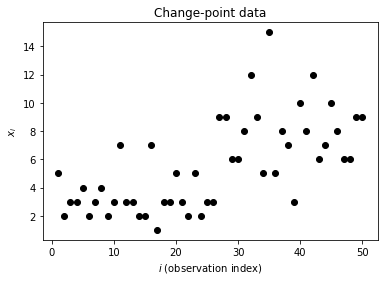

In [26]:
N = 50 # total observations
t = np.linspace(1,N) # observation times

# exact parameters
lam1 = 3
lam2 = 8.5
n = 26

# generate data
X = np.concatenate([poisson(lam=lam1, size=n),poisson(lam=lam2, size=(N-n))])

fig, ax = plt.subplots()
ax.scatter(t,X, color='k', marker='o')
ax.set_title("Change-point data")
ax.set_xlabel(r"$i$ (observation index)")
ax.set_ylabel(r"$x_i$ ")
plt.show()

We need the posterior conditionals for each variable in order to do the Gibbs sampling. A way to proceed is to determine the full joint distribution and then derive posterior conditionals from this.

$$ \begin{align} p\left(x,\lambda_1,\lambda_2,n\right) & = p\left(x_{1:n},x_{n+1:N},\lambda_1,\lambda_2,n\right) \\ & =  p\left(x_{1:n},x_{n+1:N}\,\middle| \, \lambda_1, \lambda_2, n \right)p\left(\lambda_1,\lambda_2,n\right) \end{align} $$ 

by definition of conditional probability. But since $x_{1:n}$ and $x_{1+n:N}$ are distributed differently, we have $$ \begin{align}  p\left(x_{1:n},x_{n+1:N}\,\middle| \, \lambda_1, \lambda_2, n \right)p\left(\lambda_1,\lambda_2,n\right) & = p\left(x_{1:n}\,\middle| \, \lambda_1, \lambda_2, n \right)p\left(x_{n+1:N}\,\middle| \, \lambda_1, \lambda_2, n \right)p\left(\lambda_1,\lambda_2,n\right)  \end{align}  $$ Next, note that $x_{1:n}$ depends only on $\lambda_1$ and similarly for $x_{n+1:N}$. Hence we have $$ \begin{align} p\left(x_{1:n}\,\middle| \, \lambda_1, \lambda_2, n \right)p\left(x_{n+1:N}\,\middle| \, \lambda_1, \lambda_2, n \right)p\left(\lambda_1,\lambda_2,n\right) & = p\left(x_{1:n}\,\middle| \, \lambda_1 \right)p\left(x_{n+1:N}\,\middle| \, \lambda_2 \right)p\left(\lambda_1,\lambda_2,n\right) \end{align} $$ Lastly, the "latent variables" are independent of one another, so $$ \begin{align} p\left(x_{1:n}\,\middle| \, \lambda_1 \right)p\left(x_{n+1:N}\,\middle| \, \lambda_2 \right)p\left(\lambda_1,\lambda_2,n\right) & = p\left(x_{1:n}\,\middle| \, \lambda_1 \right)p\left(x_{n+1:N}\,\middle| \, \lambda_2 \right)p\left(\lambda_1\right)p\left(\lambda_2\right)p\left( n\right)\end{align}$$ and we have written the full joint distribution as the right-hand side (the numerator) of the Bayes' theorem expression for the posterior.

At this point we may plug in the analytical expressions for each of the distributions (Poisson, Gamma, and Uniform). It helps to first take the log of this joint distribution so that the terms become additive and the exponentials in the Poisson and Gamma distribution are cancelled out. This log joint distribution is  $$ \begin{align} \log p\left(x_{1:n}\right) + \log p\left(x_{n+1:N}\right) + \log p\left(\lambda_1\right) + \log p\left(\lambda_2\right) + \log p\left(n\right) & = \sum_{i=1}^n \left[ x_i \log \lambda_1 - \lambda_1 - \log \left(x_i!\right) \right] \\ & + \sum_{i=n+1}^N \left[ x_i \log \lambda_2 - \lambda_2 - \log \left(x_i!\right) \right] \\ & + \left(a-1\right)\log \lambda_1 - b\lambda_1 - \log \Gamma\left(a\right) + a\log b \\ & + \left(a-1\right)\log \lambda_2 - b\lambda_2 - \log \Gamma\left(a\right) + a\log b  \\ & - \log N \end{align} $$

In the article, posterior conditionals are obtained by collecting only those terms dependent on that variable; the remaining terms are treated as a constant. This may make sense because after taking the log, things become additive and we can do this grouping. It would be much more difficult if things were kept multiplicative. For $\lambda_1$ we have $$ \begin{align} \log p\left( \lambda_1 \, \middle| \, n,\lambda_2,x_{1:N}\right) & = \text{const.} + \sum_{i=1}^n \left[ x_i \log \lambda_1 - \lambda_1 \right] + \left(a-1\right) \log \lambda_1 - b\lambda_1 \\ & = \text{const.} + \left( a+\sum_{i=1}^n x_i - 1\right) \log \lambda_1 - \left(n+b\right)\lambda_1 \\ & = \text{const.} + \log \text{Gamma}\left(a+\sum_{i=1}^n x_i , n+b \right)\end{align} $$ That is, we recognize in the second-to-last line that we have the analytical expression for a log-Gamma distribution with some of the constant terms missing; we lump these into the constant that already exists. This is fine, since these terms do not depend on the random variable $\lambda_1$, anyway, in the full Gamma distribution formula.

What we have ultimately determine is that the log-posterior conditional of $\lambda_1$ is a log-Gamma distribution (up to an additive constant), which is to be expected since Gamma and Poisson distributions are conjugate.

The process is analogous for $\lambda_2$: $$ \begin{align} \log p\left( \lambda_2 \, \middle| \, n,\lambda_1,x_{1:N}\right) & = \text{const.} + \sum_{i=1}^n \left[ x_i \log \lambda_1 - \lambda_1 \right] + \left(a-1\right) \log \lambda_1 - b\lambda_1 \\ & = \text{const.} + \log \text{Gamma}\left(a+\sum_{i=n+1}^N x_i , N-n+b \right)\end{align} $$

Finally, we can do this for the $n$ parameter: $$ \begin{align} p\left(n\,\middle|\,\lambda_1,\lambda_2, x_{1:N} \right) & = \sum_{i=1}^n \left[ x_i \log \lambda_1 - \lambda_1 - \log \left(x_i!\right)\right] + \sum_{i=n+1}^N \left[ x_i \log \lambda_2 - \lambda_2 - \log \left(x_i!\right)\right] \\ & =\text{const.} +  \log\left(\lambda_1\right) \sum_{i=1}^n x_i +\log \left(\lambda_2\right)\sum_{i=n+1}^N x_i  - n\lambda_1 - \left(N-n\right)\lambda_2    \end{align} $$ This doesn't have a nice distributional form. Instead, we can compute this log-posterior conditional for each $n=1,2,\ldots, N$ and normalize to obtain a distribution over $n$, and then draw samples from this as a multinomial distribution. This works because it is a discrete set?

Note that in the following implementation we are guaranteeing that the variable $n$ is always in the interval $\left[1,N\right]$. This can get subtle with the zero-based indexing in Python.

In [144]:
def sample_lambda1(X,lambda1, lambda2, n, a, b):
    """ Sample from the posterior conditional for lambda1 """
    a_new = a + np.sum(X[0:n]) # n is [1,2,..,N] but X is X[0,..,N-1]
    b_new = n + b 
    return gamma(shape=a_new,scale=1/b_new,size=1)

def sample_lambda2(X,lambda1, lambda2, n, a, b):
    """ Sample from the posterior conditional for lambda1 """
    a_new = a + np.sum(X[n:])
    b_new = len(X) - n + b 
    return gamma(shape=a_new,scale=1/b_new,size=1)

def sample_n(X, lambda1, lambda2, n, a, b):
    """ Sample from the posterior conditional for n """
    # Do I need to take an exp here somewhere?? 

    pdist = np.zeros(len(X)) # store the dist for each value of n=1,2,...,N
    for nn in range(1,len(X)+1): # nn=1,2,...,N
        pdist[nn-1] = np.log(lambda1) * np.sum(X[0:nn]) + \
            np.log(lambda2) * np.sum(X[nn:]) + \
                - nn * lambda1 - (len(X)-nn) * lambda2
    pdist = np.exp(pdist)
    # normalize
    pdist = pdist / np.sum(pdist)
    
    #return np.random.multinomial(n=1, pvals=pdist, size=1)
    return np.random.choice(a=range(1,len(pdist)+1), size=1, p=pdist )[0]

To kick off the sampling, we need to have a starting point. We can get these by sampling from the priors.

In [153]:
a = 2
b = 1

lambda1 = gamma(a,b)
lambda2 = gamma(a,b)
n = np.random.randint(low=1,high=len(X)+1) # discrete uniform

n_iters = 5200
trace = np.empty((n_iters, 3)) # [iteration, param]

for i in range(n_iters):
    # sample from the posterior conditionals to update the parameters
    lambda1 = sample_lambda1(X, lambda1, lambda2, n, a, b)
    lambda2 = sample_lambda2(X, lambda1, lambda2, n, a, b)
    n = sample_n(X, lambda1, lambda2, n, a, b)
    #print(n)
    trace[i, 0] = lambda1
    trace[i, 1] = lambda2
    trace[i, 2] = n


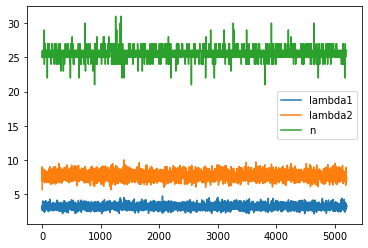

In [154]:
fig, ax = plt.subplots()
ax.plot(trace[:,0], label="lambda1")
ax.plot(trace[:,1], label="lambda2")
ax.plot(trace[:,2], label="n")
ax.legend()
plt.show()

In [156]:
lambda1_pred, lambda2_pred, n_pred = np.average(trace[200:], axis=0)

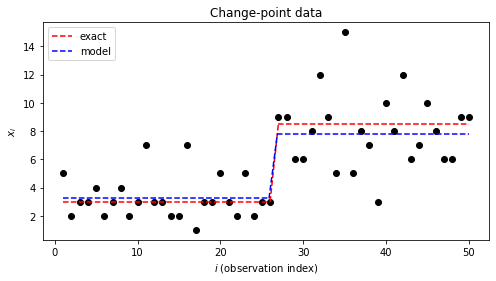

In [193]:
fig, ax = plt.subplots(figsize=(8,4))
ax.scatter(t,X, color='k', marker='o')
# exact
ax.plot([1, n], [lam1, lam1], 'r--')
ax.plot([n, n+1], [lam1, lam2], 'r--')
ax.plot([n+1, len(X)], [lam2, lam2], 'r--', label="exact")
# model
ax.plot([1, n_pred], [lambda1_pred, lambda1_pred], 'b--')
ax.plot([n_pred, n_pred+1], [lambda1_pred, lambda2_pred], 'b--')
ax.plot([n_pred+1, len(X)], [lambda2_pred, lambda2_pred], 'b--', label="model")


ax.set_title("Change-point data")
ax.set_xlabel(r"$i$ (observation index)")
ax.set_ylabel(r"$x_i$ ")
ax.legend(loc="upper left")
plt.show()

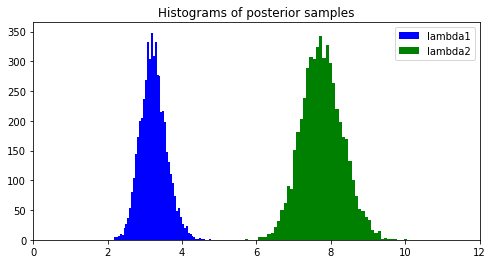

In [192]:
fig, ax = plt.subplots(figsize=(8,4))

ax.hist(trace[:,0], bins=50, color='b', label='lambda1')
ax.hist(trace[:,1], bins=50, color='g', label='lambda2')
ax.set_xlim([0,12])
ax.set_title("Histograms of posterior samples")

ax.legend()
plt.show()

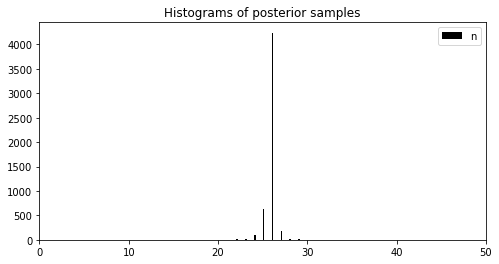

In [191]:
fig, ax = plt.subplots(figsize=(8,4))
ax.hist(trace[:,2], bins=50, color='k', label='n')
ax.set_xlim([0,50])
ax.set_title("Histograms of posterior samples")
ax.legend()
plt.show()